In [ ]:
%pip install fastparquet
%pip install evaluate
%pip install datasets
%pip install transformers[torch]
%pip install sklearn-crfsuite
%pip install pytorch-crf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)

In [ ]:
import argparse
import gc
import json
import logging
import os
import random
from itertools import chain
from pathlib import Path
from google.colab import drive
import numpy as np
import pandas as pd
import yaml
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import warnings
import torch
import sys
from dataclasses import dataclass, field
from typing import Optional
import torch.nn as nn
from torchcrf import CRF

import evaluate
import numpy as np
import transformers
from datasets import ClassLabel, load_dataset
from transformers import (
    AutoConfig,
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    HfArgumentParser,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments,
    set_seed,
    AutoModel,
    RobertaTokenizerFast
)
from transformers.trainer_utils import get_last_checkpoint, is_main_process
from transformers.utils import check_min_version
drive.mount('/content/drive', force_remount=True)
warnings.filterwarnings("ignore", category=UserWarning)

logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

Mounted at /content/drive


In [ ]:
def chunk_tokens_labels(df: pd.DataFrame, max_length: int):
    """
    This function chunks tokens and their respective labels to
    max_length token length
    """
    index_list = []
    tokens_list = []
    labels_list = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if len(row["token_label_ids"]) > max_length:
            remaining_tokens = row["tokens"]
            remaining_labels = row["token_label_ids"]

            # While the remaining list is larger than max_length,
            # truncate and append
            while len(remaining_labels) > max_length:
                index_list.append(index)
                tokens_list.append(remaining_tokens[:max_length])
                labels_list.append(remaining_labels[:max_length])
                remaining_tokens = remaining_tokens[max_length:]
                remaining_labels = remaining_labels[max_length:]
            # Append last chunk
            index_list.append(index)
            tokens_list.append(remaining_tokens)
            labels_list.append(remaining_labels)
        else:
            index_list.append(index)
            tokens_list.append(row["tokens"])
            labels_list.append(row["token_label_ids"])

    return pd.DataFrame(
        {"index": index_list, "tokens": tokens_list, "labels": labels_list}
    )


def write_df_to_json(df: pd.DataFrame, path_to_json: str):
    """
    This function writes pandas dataframes into a compatible json format
    to be used by hf_token_classification.py
    """
    index_list = df["index"].values.tolist()
    tokens_list = df["tokens"].values.tolist()
    labels_list = df["labels"].values.tolist()
    data_list = []
    for i in tqdm(range(len(tokens_list)), total=len(tokens_list)):
        index = index_list[i]
        tokens = tokens_list[i]
        labels = [str(el) for el in labels_list[i]]
        data_list.append(
            {"index": index, "tokens": tokens, "ner_tags": labels}
        )
    with open(path_to_json, "w") as f:
        f.write(json.dumps(data_list))


def prep_data(path_to_file: str, max_length: int, split: str):
    dataset = split
    logger.info(f"Loading {dataset} dataset from file")
    df = pd.read_parquet(path_to_file, engine="fastparquet")
    if df.index.name != "index":
        df.set_index("index", inplace=True)

    # the external NER Classification script needs a target column
    # for the test set as well, which is not available.
    # Therefore, we're subsidizing this column with a fake label column
    # Which we're not using anyway, since we're only using the test set
    # for predictions.
    if "token_label_ids" not in df.columns:
        df["token_label_ids"] = df["tokens"].apply(
            lambda x: np.zeros(len(x), dtype=int)
        )
    df = df[["tokens", "token_label_ids"]]

    logger.info(f"Initial {dataset} data length: {len(df)}")
    df = chunk_tokens_labels(df, max_length=max_length)
    logger.info(
        f"{dataset} data length after chunking to max {max_length} tokens: {len(df)}"
    )

    return df


def convert_parquet_data_to_json(
    input_folder_path: str,
    input_train_file_name: str,
    input_test_file_name: str,
    final_test_final_name: str,
    max_length: int,
    val_size: float = 0.1,
    output_train_file_name: str = "",
    output_val_file_name: str = "",
    output_val_labeled_file_name: str = "",
    output_test_file_name: str = "",
    output_final_test_file_name: str = "",
    seed: int = 0,
):
    """
    This function takes a parquet file with (at least) the text split and the token
    label ids, and converts it to train, validation, and test data.
    Each chunk is saved as a separate json file

    param input_folder_path: path to data dir
    param input_train_file_name: the input train file name
    param input_test_file_name: the input test file name
    param max_length: max token length
    param val_size: validation size as a fraction of the total
    param output_train_file_name: json train file name
    param output_val_file_name: json validation file name
    param output_test_file_name: json test file name

    returns: None
    """

    print("Loading train, validation and test datasets")

    # Loading and prepping train dataset
    train_df = prep_data(
        path_to_file=Path(input_folder_path) / Path(input_train_file_name),
        max_length=max_length,
        split='train',
    )

    print("Splitting train data into train and validation splits")
    train_df, val_df_labeled = train_test_split(
        train_df, test_size=val_size, random_state=seed, shuffle=True
    )

    # Loading and prepping validation dataset
    val_df = prep_data(
        path_to_file=Path(input_folder_path) / Path(input_test_file_name),
        max_length=max_length,
        split='val',
    )

    test_df = prep_data(
        path_to_file=Path(input_folder_path) / Path(final_test_final_name),
        max_length=max_length,
        split='final test',
    )


    print(f"Final train size: {len(train_df)}")
    print(f"Final val_df_labeled size: {len(val_df_labeled)}")

    print(f"Final validation size: {len(val_df)}")
    print(f"Final test size: {len(test_df)}")


    print("Writing train df to json...")
    write_df_to_json(
        train_df,
        f"{input_folder_path}/{output_train_file_name}",
    )


    print("Writing val labeled df to json...")
    write_df_to_json(
        val_df_labeled,
        f"{input_folder_path}/{output_val_labeled_file_name}",
    )

    print("Writing validation df to json...")
    write_df_to_json(
        val_df,
        f"{input_folder_path}/{output_test_file_name}",
    )

    print("Writing test df to json...")
    write_df_to_json(
        test_df,
        f"{input_folder_path}/{output_final_test_file_name}",
    )



In [ ]:
project_root  = r'/content/drive/My Drive/DAGPAP24'
config_yml = 'config_baseline.yml'
config_path = os.path.join(project_root, config_yml)

with open(config_path) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
path_to_data_folder = project_root
input_train_file_name = params["data"]["train_file"]
input_test_file_name = params["data"]["test_file"]
input_final_test_file_name = 'test_data.parquet'
output_train_file_name = params["data"]["train_file_name"]
output_val_file_name = params["data"]["validation_file_name"]
output_test_file_name = params["data"]["test_file_name"]
output_final_test_file_name = 'data_gen_content_test.json'
output_val_labeled_name = 'val_labeled.json'


In [ ]:
convert_parquet_data_to_json(
    input_folder_path=path_to_data_folder,
    input_train_file_name=input_train_file_name,
    input_test_file_name=input_test_file_name,
    final_test_final_name = input_final_test_file_name,
    max_length=params["bert"]["MAX_LENGTH"],
    val_size=params["environment"]["val_size"],
    output_train_file_name=output_train_file_name,
    output_val_file_name=output_val_file_name,
    output_val_labeled_file_name=output_val_labeled_name,
    output_test_file_name=output_test_file_name,
    output_final_test_file_name=output_final_test_file_name,
    seed=params["environment"]["SEED"],
)

Loading train, validation and test datasets


  0%|          | 0/5000 [00:00<?, ?it/s]

Splitting train data into train and validation splits


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Final train size: 45543
Final val_df_labeled size: 11386
Final validation size: 57160
Final test size: 228492
Writing train df to json...


  0%|          | 0/45543 [00:00<?, ?it/s]

Writing val labeled df to json...


  0%|          | 0/11386 [00:00<?, ?it/s]

Writing validation df to json...


  0%|          | 0/57160 [00:00<?, ?it/s]

Writing test df to json...


  0%|          | 0/228492 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

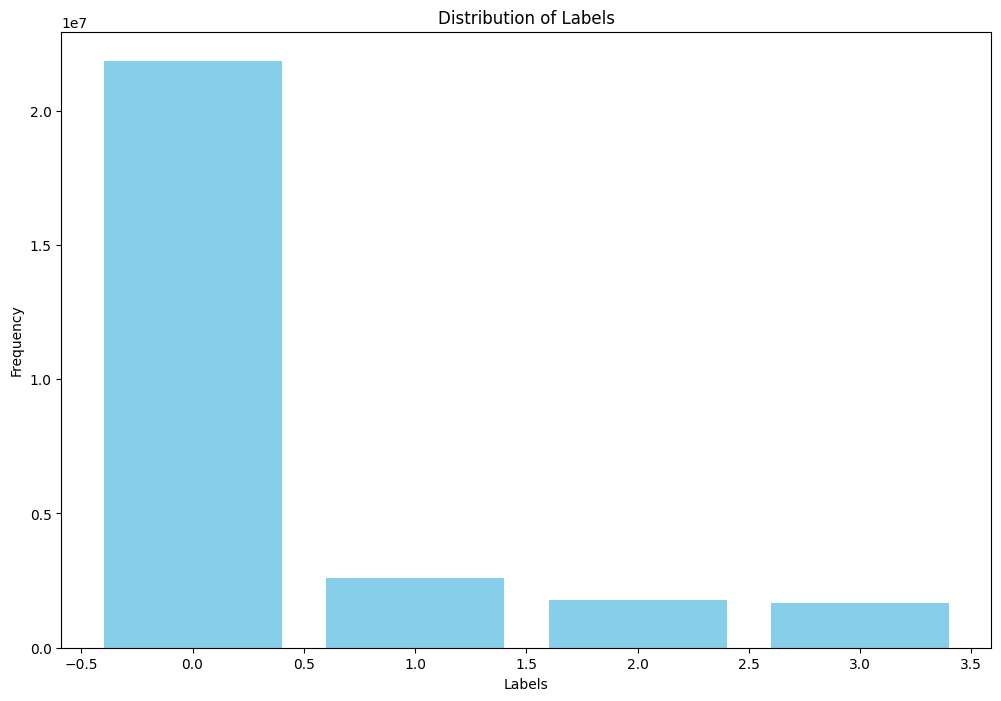

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

train_df = prep_data(
    path_to_file=Path(path_to_data_folder) / Path(input_train_file_name),
    max_length=params["bert"]["MAX_LENGTH"],
    split='train',
)

all_labels = [label for sublist in train_df['labels'] for label in sublist]
label_counts = Counter(all_labels)

labels, counts = zip(*label_counts.items())  # Separate the labels and counts

# Sort the labels and counts so they appear in order on the x-axis
sorted_labels_counts = sorted(zip(labels, counts))
sorted_labels, sorted_counts = zip(*sorted_labels_counts)

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.bar(sorted_labels, sorted_counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.xticks(rotation=0)  # Adjust rotation based on label overlap
plt.show()

In [ ]:
# # create hf_token_classification.py config file
config_dict = {
    "train_file": f"{path_to_data_folder}/{output_train_file_name}",
    "validation_file": f"{path_to_data_folder}/{output_val_file_name}",
    "validation_labeled_file": f"{path_to_data_folder}/{output_val_labeled_name}",
    "test_file": f"{path_to_data_folder}/{output_test_file_name}",
    "final_test_file": f"{path_to_data_folder}/{output_final_test_file_name}",
    "output_dir": os.path.join(path_to_data_folder, "roberta-10epoch"),
    "model_name_or_path": 'roberta-base',
    "num_train_epochs": 5,
    "per_device_train_batch_size": params["bert"]["per_device_train_batch_size"],
    "per_device_eval_batch_size": params["bert"]["per_device_eval_batch_size"],
    "save_steps": params["bert"]["save_steps"],
    "overwrite_output_dir": params["bert"]["overwrite_output_dir"],
    "seed": params["environment"]["SEED"],
    "do_train": params["bert"]["do_train"],
    "report_to": params["bert"]["report_to"],
    "do_eval": params["bert"]["do_eval"],
    "do_predict": params["bert"]["do_predict"],
    "preprocessing_num_workers": params["bert"]["preprocessing_num_workers"],
    "eval_accumulation_steps": params["bert"]["eval_accumulation_steps"],
    "log_level": params["bert"]["log_level"],
}

# save hf_token_classification.py config file
hf_config_file_path = os.path.join(project_root, "config_huggingface.json")
with open(hf_config_file_path, "w") as f:
    json.dump(config_dict, f, indent=4)

In [ ]:
params["bert"]["overwrite_output_dir"]

True

In [ ]:
print(config_dict["validation_labeled_file"])

/content/drive/My Drive/DAGPAP24/val_labeled.json


In [ ]:
check_min_version("4.5.0.dev0")

logger = logging.getLogger(__name__)

In [ ]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer
    we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={
            "help": "Path to pretrained model or model \
                     identifier from huggingface.co/models"
        }
    )
    config_name: Optional[str] = field(
        default=None,
        metadata={
            "help": "Pretrained config name or path if \
                     not the same as model_name"
        },
    )
    tokenizer_name: Optional[str] = field(
        default=None,
        metadata={
            "help": "Pretrained tokenizer name or path \
                     if not the same as model_name"
        },
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={
            "help": "Where do you want to store the pretrained \
                     models downloaded from huggingface.co"
        },
    )
    model_revision: str = field(
        default="main",
        metadata={
            "help": "The specific model version to use \
                    (can be a branch name, tag name or commit id)."
        },
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": "Will use the token generated when running `\
                transformers-cli login` (necessary to use this script \
            with private models)."
        },
    )


@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going
    to input our model for training and eval.
    """

    task_name: Optional[str] = field(
        default="ner", metadata={"help": "The name of the task (ner, pos...)."}
    )
    dataset_name: Optional[str] = field(
        default=None,
        metadata={
            "help": "The name of the dataset to use \
            (via the datasets library)."
        },
    )
    dataset_config_name: Optional[str] = field(
        default=None,
        metadata={
            "help": "The configuration name of the dataset \
                     to use (via the datasets library)."
        },
    )
    train_file: Optional[str] = field(
        default=None,
        metadata={
            "help": "The input training data file (a csv or JSON file)."
        },
    )
    validation_labeled_file: Optional[str] = field(
        default=None,
        metadata={
            "help": "An optional input evaluation data file \
                    to evaluate on (a csv or JSON file)."
        },
    )
    validation_file: Optional[str] = field(
        default=None,
        metadata={
            "help": "An optional input evaluation data file \
                    to evaluate on (a csv or JSON file)."
        },
    )
    test_file: Optional[str] = field(
        default=None,
        metadata={
            "help": "An optional input test data file to \
                     predict on (a csv or JSON file)."
        },
    )
    final_test_file:  Optional[str] = field(
        default=None,
        metadata={
            "help": "An optional input final test data file to \
                     predict on (a csv or JSON file)."
        },
    )
    overwrite_cache: bool = field(
        default=False,
        metadata={"help": "Overwrite the cached training and evaluation sets"},
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={
            "help": "The number of processes to use for the preprocessing."
        },
    )
    pad_to_max_length: bool = field(
        default=False,
        metadata={
            "help": "Whether to pad all samples to model maximum sentence \
                length. If False, will pad the samples dynamically when \
                batching to the maximum length in the batch. \
                More efficient on GPU but very bad for TPU."
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, \
                truncate the number of training examples to this \
                value if set."
        },
    )
    max_val_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, \
                truncate the number of validation examples to this \
                value if set."
        },
    )
    max_test_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, \
                truncate the number of test examples to this \
                value if set."
        },
    )
    label_all_tokens: bool = field(
        default=False,
        metadata={
            "help": "Whether to put the label for one word on all tokens \
                of generated by that word or just on the one \
                (in which case the other tokens will have a padding index)."
        },
    )
    return_entity_level_metrics: bool = field(
        default=False,
        metadata={
            "help": "Whether to return all the entity levels during \
                     evaluation or just the overall ones."
        },
    )

    def __post_init__(self):
        if (
            self.dataset_name is None
            and self.train_file is None
            and self.validation_file is None
        ):
            raise ValueError(
                "Need either a dataset name or a training/validation file."
            )
        else:
            if self.train_file is not None:
                extension = self.train_file.split(".")[-1]
                assert extension in [
                    "csv",
                    "json",
                ], "`train_file` should be a csv or a json file."
            if self.validation_file is not None:
                extension = self.validation_file.split(".")[-1]
                assert extension in [
                    "csv",
                    "json",
                ], "`validation_file` should be a csv or a json file."
        self.task_name = self.task_name.lower()


In [ ]:
parser = HfArgumentParser(
      (ModelArguments, DataTrainingArguments, TrainingArguments)
  )

model_args, data_args, training_args = parser.parse_json_file(
        json_file=os.path.abspath(hf_config_file_path)
    )

In [ ]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=True,
do_train=True,
eval_accumulation_steps=5,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=None,
eval_strategy=no,
evaluation_strategy=None,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config=

In [ ]:
# Detecting last checkpoint.
last_checkpoint = None
if (
    os.path.isdir(training_args.output_dir)
    and training_args.do_train
    and not training_args.overwrite_output_dir
):
    last_checkpoint = get_last_checkpoint(training_args.output_dir)
    print("aici")
    if (
        last_checkpoint is None
        and len(os.listdir(training_args.output_dir)) > 0
    ):
        raise ValueError(
            f"Output directory ({training_args.output_dir}) \
                already exists and is not empty. \
                Use --overwrite_output_dir to overcome."
        )
    elif last_checkpoint is not None:
        logger.info(
            f"Checkpoint detected, resuming training at {last_checkpoint}.\
                  To avoid this behavior, change the `--output_dir` or \
                add `--overwrite_output_dir` to train from scratch."
        )

In [ ]:
last_checkpoint = get_last_checkpoint(training_args.output_dir)


In [ ]:
print(last_checkpoint)

None


In [ ]:
# Setup logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)
logger.setLevel(
    logging.INFO
    if is_main_process(training_args.local_rank)
    else logging.WARN
)

# Log on each process the small summary:
logger.warning(
    f"Process rank: {training_args.local_rank}, \
        device: {training_args.device}, n_gpu: {training_args.n_gpu}"
    + f"distributed training: {bool(training_args.local_rank != -1)},\
          16-bits training: {training_args.fp16}"
)
# Set the verbosity to info of the Transformers
# logger (on main process only):
if is_main_process(training_args.local_rank):
    transformers.utils.logging.set_verbosity_info()
    transformers.utils.logging.enable_default_handler()
    transformers.utils.logging.enable_explicit_format()
logger.info("Training/evaluation parameters %s", training_args)

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=True,
do_train=True,
eval_accumulation_steps=5,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=None,
eval_strategy=no,
evaluation_strategy=None,
fp16=False,
fp16_backend=auto,
fp16_full_eval=Fa

In [ ]:
set_seed(training_args.seed)


In [ ]:
if data_args.dataset_name is not None:
    # Downloading and loading a dataset from the hub.
    datasets = load_dataset(
        data_args.dataset_name, data_args.dataset_config_name
    )
else:
    data_files = {}
    if data_args.train_file is not None:
        data_files["train"] = data_args.train_file
    if data_args.validation_labeled_file is not None:
        data_files["validation_labeled"] = data_args.validation_labeled_file
    if data_args.validation_file is not None:
        data_files["validation"] = data_args.validation_file
    if data_args.test_file is not None:
        data_files["test"] = data_args.test_file
    if data_args.final_test_file is not None:
        data_files["final_test"] = data_args.final_test_file
    extension = data_args.train_file.split(".")[-1]
    datasets = load_dataset(extension, data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation_labeled split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating final_test split: 0 examples [00:00, ? examples/s]

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 45543
    })
    validation_labeled: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 11386
    })
    validation: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 11386
    })
    test: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 57160
    })
    final_test: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 228492
    })
})

In [ ]:
if training_args.do_train:
    column_names = datasets["train"].column_names
    features = datasets["train"].features
else:
    column_names = datasets["validation"].column_names
    features = datasets["validation"].features

In [ ]:
text_column_name = (
    "tokens" if "tokens" in column_names else column_names[0]
)
label_column_name = (
    f"{data_args.task_name}_tags"
    if f"{data_args.task_name}_tags" in column_names
    else column_names[1]
)

In [ ]:
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    # label_list = list(str(x) for x in range(4))
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    label_to_id = {i: i for i in range(len(label_list))}
else:
    label_list = get_label_list(datasets["train"][label_column_name])
    label_to_id = {l: i for i, l in enumerate(label_list)}
num_labels = len(label_list)

# MODEL

In [ ]:
class BiLSTM_CRF_SciBERT(nn.Module):
    def __init__(self, num_labels, config, hidden_size=256, num_layers=1):
        super(BiLSTM_CRF_SciBERT, self).__init__()
        self.bert = AutoModelForTokenClassification.from_pretrained(
            model_args.model_name_or_path,
            from_tf=bool(".ckpt" in model_args.model_name_or_path),
            config=config,
            cache_dir=model_args.cache_dir,
            revision=model_args.model_revision,
            use_auth_token=True if model_args.use_auth_token else None,
        )
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=True,
                            batch_first=True)
        self.classifier = nn.Linear(hidden_size * 2, num_labels)
        self.dropout = nn.Dropout(0.1)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        lstm_output, _ = self.lstm(sequence_output)
        emissions = self.classifier(lstm_output)

        if labels is not None:
            # Mask for computing CRF loss that excludes the padding and special tokens marked with -100
            active_loss = labels != -100
            active_labels = labels[active_loss]
            emissions = emissions[active_loss]

            # Since CRF expects a batch_first format, make sure to adjust the reshaping
            # Calculate the actual batch_size dynamically based on the active part of the batch
            batch_size = emissions.size(0)

            # Apply CRF loss only to non-masked (active) parts of the batch
            loss = -self.crf(emissions, active_labels, mask=active_loss[:, :emissions.size(1)].byte())
            return loss
        else:
            # When no labels are provided, use CRF to decode the best path
            return self.crf.decode(emissions)

# First Approach Baseline SciBert




In [ ]:
config = AutoConfig.from_pretrained(
    model_args.config_name
    if model_args.config_name
    else model_args.model_name_or_path,
    num_labels=num_labels,
    finetuning_task=data_args.task_name,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_args.tokenizer_name
    if model_args.tokenizer_name
    else model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    use_fast=True,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)
model = AutoModelForTokenClassification.from_pretrained(
    model_args.model_name_or_path,
    from_tf=bool(".ckpt" in model_args.model_name_or_path),
    config=config,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)


In [ ]:
print(model_args.model_name_or_path)
print(model_args.tokenizer_name)


roberta-base
None


# Second Approach SciBert LSTM CRF

In [ ]:
config = AutoConfig.from_pretrained(
    model_args.config_name
    if model_args.config_name
    else model_args.model_name_or_path,
    num_labels=num_labels,
    finetuning_task=data_args.task_name,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_args.tokenizer_name
    if model_args.tokenizer_name
    else model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    use_fast=True,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)
model = BiLSTM_CRF_SciBERT(num_labels=num_labels, config=config)

# Third Approach RoBERTa

In [ ]:
config = AutoConfig.from_pretrained(
    'roberta-base',
    num_labels=num_labels,
    finetuning_task=data_args.task_name,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

tokenizer = RobertaTokenizerFast.from_pretrained(
    'roberta-base',
    add_prefix_space=True,
    use_fast=True)

model = AutoModelForTokenClassification.from_pretrained(
    'roberta-base',
    config=config,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

In [ ]:
del model
torch.cuda.empty_cache()


NameError: name 'model' is not defined

# Load fine-tuned Roberta

In [ ]:
config_dict["output_dir"] = '/content/drive/My Drive/DAGPAP24/roberta'

In [ ]:
config = AutoConfig.from_pretrained(
    'roberta-base',
    num_labels=num_labels,
    finetuning_task=data_args.task_name,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

tokenizer = RobertaTokenizerFast.from_pretrained(
    config_dict["output_dir"],
    add_prefix_space=True,
    use_fast=True)

model = AutoModelForTokenClassification.from_pretrained(
    config_dict["output_dir"],
    config=config,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

OSError: Can't load tokenizer for '/content/drive/My Drive/DAGPAP24/roberta-10epoch'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '/content/drive/My Drive/DAGPAP24/roberta-10epoch' is the correct path to a directory containing all relevant files for a RobertaTokenizerFast tokenizer.

In [ ]:
tokenizer

RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [ ]:
# Tokenizer check: this script requires a fast tokenizer.
if not isinstance(tokenizer, PreTrainedTokenizerFast):
    raise ValueError(
        "This example script only works for models that have a \
        fast tokenizer. Checkout the big table of models \
        at https://huggingface.co/transformers/index.html#bigtable \
        to find the model types that meet this requirement"
    )

# Preprocessing the dataset
# Padding strategy
padding = "max_length" if data_args.pad_to_max_length else False
max_length = data_args.max_length if data_args.pad_to_max_length else 512

# Text processing

In [ ]:
# Tokenize all texts and align the labels with them.
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples[text_column_name],
        padding=padding,
        truncation=True,
        max_length=max_length,
        is_split_into_words=True,
    )
    labels = []
    for i, label in enumerate(examples[label_column_name]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
            else:
                label_ids.append(label_to_id[label[word_idx]])
            previous_word_idx = word_idx

        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Tokenize all texts and align the labels with them.
def tokenize_and_align_labels_updated(examples):
    tokenized_inputs = tokenizer(
        examples[text_column_name],
        padding=padding,
        truncation=True,
        max_length=max_length,
        # We use this argument because the texts in our dataset are lists
        # of words (with a label for each word).
        is_split_into_words=True,
    )
    all_labels = []
    all_masks = []
    for i, label in enumerate(examples[label_column_name]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        mask = []
        first_token = True

        for j, word_idx in enumerate(word_ids):
            # Special tokens have a word id that is None. We set the label
            # to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
              if first_token:
                label_ids.append(label_to_id[label[0]])
                mask.append(1)
              else:
                label_ids.append(-100)
                mask.append(0)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
                mask.append(1)
            # For the other tokens in a word, we set the label
            # to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
              if data_args.label_all_tokens:
                label_ids.append(label_to_id[label[word_idx]])
                mask.append(1)
              else:
                label_ids.append(-100)  # For subsequent tokens in the same word, use -100
                mask.append(0)
            previous_word_idx = word_idx
            first_token = False

        all_labels.append(label_ids)
        all_masks.append(mask)
    tokenized_inputs["labels"] = all_labels
    tokenized_inputs["attention_mask"] = all_masks  # Update the attention mask

    return tokenized_inputs

In [ ]:
datasets


DatasetDict({
    train: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 45543
    })
    validation_labeled: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 11386
    })
    validation: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 11386
    })
    test: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 57160
    })
    final_test: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 228492
    })
})

In [ ]:
if training_args.do_train:
    if "train" not in datasets:
        raise ValueError("--do_train requires a train dataset")
    train_dataset = datasets["train"]
    if data_args.max_train_samples is not None:
        train_dataset = train_dataset.select(
            range(data_args.max_train_samples)
        )
    train_dataset = train_dataset.map(
        tokenize_and_align_labels,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        load_from_cache_file=not data_args.overwrite_cache,
    )

Map (num_proc=16):   0%|          | 0/45543 [00:00<?, ? examples/s]

In [ ]:
train_dataset['ner_tags'][0]

In [ ]:
print(train_dataset['ner_tags'][1])
print(train_dataset['input_ids'][1])
print(train_dataset['labels'][1])
print(train_dataset['attention_mask'][1])

['3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3',

In [ ]:
if training_args.do_eval:
    if "validation" not in datasets:
        raise ValueError("--do_eval requires a validation dataset")
    eval_dataset = datasets["validation"]
    if data_args.max_val_samples is not None:
        eval_dataset = eval_dataset.select(
            range(data_args.max_val_samples)
        )
    eval_dataset = eval_dataset.map(
        tokenize_and_align_labels,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        load_from_cache_file=not data_args.overwrite_cache,
    )

Map (num_proc=16):   0%|          | 0/11386 [00:00<?, ? examples/s]

In [ ]:
if training_args.do_eval:
    if "validation_labeled" not in datasets:
        raise ValueError("--do_eval requires a validation dataset")
    eval_labeled_dataset = datasets["validation_labeled"]
    if data_args.max_val_samples is not None:
        eval_labeled_dataset = eval_labeled_dataset.select(
            range(data_args.max_val_samples)
        )
    eval_labeled_dataset = eval_labeled_dataset.map(
        tokenize_and_align_labels,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        load_from_cache_file=not data_args.overwrite_cache,
    )

Map (num_proc=16):   0%|          | 0/11386 [00:00<?, ? examples/s]

In [ ]:
if training_args.do_predict:
    if "test" not in datasets:
        raise ValueError("--do_predict requires a test dataset")
    test_dataset = datasets["test"]
    if data_args.max_test_samples is not None:
        test_dataset = test_dataset.select(
            range(data_args.max_test_samples)
        )
    test_dataset = test_dataset.map(
        tokenize_and_align_labels,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        load_from_cache_file=not data_args.overwrite_cache,
    )

Map (num_proc=16):   0%|          | 0/57160 [00:00<?, ? examples/s]

In [ ]:
if training_args.do_predict:
    if "final_test" not in datasets:
        raise ValueError("--do_predict requires a final test dataset")
    final_test_dataset = datasets["final_test"]
    if data_args.max_test_samples is not None:
        final_test_dataset = final_test_dataset.select(
            range(data_args.max_test_samples)
        )
    final_test_dataset = final_test_dataset.map(
        tokenize_and_align_labels,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        load_from_cache_file=not data_args.overwrite_cache,
    )

Map (num_proc=16):   0%|          | 0/228492 [00:00<?, ? examples/s]

In [ ]:
print(len(final_test_dataset))

228492


In [ ]:
# Data collator
data_collator = DataCollatorForTokenClassification(
    tokenizer, pad_to_multiple_of=8 if training_args.fp16 else None
)

# Metrics
metric = evaluate.load("f1")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    merged_predictions = [
        label_list[p]
        for (p, l) in zip(predictions.flatten(), labels.flatten())
        if l != -100
    ]
    merged_labels = [
        label_list[l]
        for (p, l) in zip(predictions.flatten(), labels.flatten())
        if l != -100
    ]

    results = metric.compute(
        predictions=merged_predictions,
        references=merged_labels,
        average="macro",
    )

    if data_args.return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "f1": results["f1"],
        }

# Train

In [ ]:
config

In [ ]:
model

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

In [ ]:
train_df = prep_data(
    path_to_file=Path(path_to_data_folder) / Path(input_train_file_name),
    max_length=params["bert"]["MAX_LENGTH"],
    split='train',
)

all_labels = [label for sublist in train_df['labels'] for label in sublist]
count_labels = Counter(all_labels)

# Calculating class weights
total_count = sum(count_labels.values())
class_weights = {cls: total_count / count for cls, count in count_labels.items()}

# Convert class weights to a tensor
weights_tensor = torch.tensor([class_weights[i] for i in sorted(class_weights)])

INFO:__main__:Loading train dataset from file
INFO:__main__:Initial train data length: 5000


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:__main__:train data length after chunking to max 512 tokens: 56929


In [ ]:
class_weights

{0: 1.2757154582845969,
 1: 10.752722669550689,
 3: 16.736793318808832,
 2: 15.7783863876645}

In [ ]:
weights_tensor

tensor([ 1.2757, 10.7527, 15.7784, 16.7368], device='cuda:0')

In [ ]:
from torch.nn import CrossEntropyLoss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a CrossEntropyLoss instance with class weights
weights_tensor = weights_tensor.to(device)  # device should be something like 'cuda' or 'cpu'
loss_fct = CrossEntropyLoss(weight=weights_tensor)

In [ ]:
weights_tensor

tensor([ 1.2757, 10.7527, 15.7784, 16.7368], device='cuda:0')

In [ ]:
loss_fct

CrossEntropyLoss()

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, model, args, loss_fct, **kwargs):
        super().__init__(model, args, **kwargs)
        self.loss_fct = loss_fct

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").to(device)  # Ensure labels are on the correct device
        outputs = model(**inputs)
        logits = outputs.logits

        # Compute the loss only for non-ignored indices
        active_loss = labels.view(-1) != -100  # ignore index
        active_labels = labels.view(-1)[active_loss]
        active_logits = logits.view(-1, model.config.num_labels)[active_loss]

        # Calculate loss using the class weighted loss function
        loss = self.loss_fct(active_logits, active_labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
custom_trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset if training_args.do_train else None,
    eval_dataset=eval_dataset if training_args.do_eval else None,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    loss_fct=loss_fct  # Pass the custom loss function
)

In [ ]:
# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset if training_args.do_train else None,
    eval_dataset=eval_dataset if training_args.do_eval else None,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# Training
if training_args.do_train:
    if last_checkpoint is not None:
        checkpoint = last_checkpoint
    elif os.path.isdir(model_args.model_name_or_path):
        checkpoint = model_args.model_name_or_path
    else:
        checkpoint = None
    print(checkpoint)
    train_result = trainer.train(resume_from_checkpoint=checkpoint)
    metrics = train_result.metrics
    trainer.save_model()  # Saves the tokenizer too for easy upload

    max_train_samples = (

        data_args.max_train_samples
        if data_args.max_train_samples is not None
        else len(train_dataset)
    )
    metrics["train_samples"] = min(max_train_samples, len(train_dataset))

    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()

None


Step,Training Loss
500,0.197400
1000,0.073700
1500,0.074900
2000,0.067600
2500,0.052500
3000,0.054000
3500,0.057600
4000,0.046700
4500,0.041600
5000,0.036000


***** train metrics *****
  epoch                    =        5.0
  total_flos               = 69270059GF
  train_loss               =     0.0233
  train_runtime            = 1:58:10.90
  train_samples            =      56929
  train_samples_per_second =     40.142
  train_steps_per_second   =      5.018


In [ ]:
if training_args.do_eval:
    logger.info("*** Evaluate ***")

    metrics = trainer.evaluate()

    max_val_samples = (
        data_args.max_val_samples
        if data_args.max_val_samples is not None
        else len(eval_dataset)
    )
    metrics["eval_samples"] = min(max_val_samples, len(eval_dataset))

    trainer.log_metrics("eval", metrics)
    trainer.save_metrics("eval", metrics)


INFO:__main__:*** Evaluate ***


***** eval metrics *****
  epoch                   =        3.0
  eval_f1                 =     0.9911
  eval_loss               =     0.0241
  eval_runtime            = 0:02:31.36
  eval_samples            =      11386
  eval_samples_per_second =     75.224
  eval_steps_per_second   =      9.408


In [ ]:
if training_args.do_predict:
    logger.info("*** Predict ***")

    predictions, labels, metrics = trainer.predict(test_dataset)
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    trainer.log_metrics("test", metrics)
    trainer.save_metrics("test", metrics)

INFO:__main__:*** Predict ***


***** test metrics *****
  test_f1                 =     0.2196
  test_loss               =     2.7451
  test_runtime            = 0:15:10.84
  test_samples_per_second =     62.755
  test_steps_per_second   =      7.844


In [ ]:
if training_args.do_predict:
    print("*** Predict final_test ***")

    predictions, labels, metrics = trainer.predict(final_test_dataset)
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    trainer.log_metrics("final_test", metrics)
    trainer.save_metrics("final_test", metrics)

*** Predict final_test ***


***** final_test metrics *****
  test_f1                 =     0.2191
  test_loss               =     2.9432
  test_runtime            = 1:28:38.44
  test_samples_per_second =     42.962
  test_steps_per_second   =       5.37


In [ ]:
print(training_args.output_dir)

/content/drive/My Drive/DAGPAP24/roberta-10epoch


In [ ]:
# Save predictions
output_test_predictions_file = os.path.join(
    training_args.output_dir, "test_predictions.txt"
)

output_json_predictions_file = os.path.join(
    training_args.output_dir, "test_predictions.json"
)

if trainer.is_world_process_zero():
    with open(output_test_predictions_file, "w") as writer:
        for prediction in true_predictions:
            writer.write(" ".join([str(i) for i in prediction]) + "\n")

    # save preds to json
    assert len(predictions) == len(final_test_dataset)

    data_list = []
    for i in range(len(predictions)):
        data_list.append(
            {
                "index": final_test_dataset[i]["index"],
                "predictions": predictions[i].tolist(),
            }
        )
    with open(output_json_predictions_file, "w") as f:
        f.write(json.dumps(data_list))

In [ ]:
training_args.output_dir

'/content/drive/My Drive/DAGPAP24/roberta-10epoch'

In [ ]:
def convert_preds_to_original_format(
    path_to_test_data: str = "",
    path_to_test_preds: str = "",
    path_to_final_output: str = "",
):
    """
    This function takes the chunked preds and groups them into the original format
    """

    orig_test_data = pd.read_parquet(path_to_test_data, engine="fastparquet")
    if orig_test_data.index.name != "index":
        orig_test_data.set_index("index", inplace=True)

    with open(path_to_test_preds, "r") as f:
        test_preds = json.load(f)

    test_preds_df = pd.DataFrame(test_preds).groupby(by="index").agg(list)

    test_preds_df["preds"] = test_preds_df["predictions"].apply(
        lambda x: sum(x, [])
    )

    for index, row in test_preds_df.iterrows():
        if len(row["preds"]) > len(orig_test_data.loc[index, "tokens"]):
            test_preds_df.loc[index, "preds"] = row["preds"][
                : len(orig_test_data.loc[index, "tokens"])
            ]

        elif len(row["preds"]) < len(orig_test_data.loc[index, "tokens"]):
            test_preds_df.loc[index, "preds"] = row["preds"] + 0 * (
                len(orig_test_data.loc[index, "tokens"]) - len(row["preds"])
            )
    for index, row in test_preds_df.iterrows():
        assert len(row["preds"]) == len(orig_test_data.loc[index, "tokens"])

    pd.DataFrame(test_preds_df["preds"]).to_parquet(path_to_final_output)
    print(f"final dataset saved to {path_to_final_output}")

    return None

In [ ]:
print(params)

{'data': {'path_to_data': 'data', 'train_file': 'train_data.parquet', 'test_file': 'dev_data.parquet', 'train_file_name': 'data_gen_content_train.json', 'validation_file_name': 'data_gen_content_val.json', 'test_file_name': 'data_gen_content_dev.json', 'pred_file_name': 'predictions.parquet'}, 'environment': {'SEED': 0, 'val_size': 0.2}, 'bert': {'model': 'allenai/scibert_scivocab_uncased', 'MAX_LENGTH': 512, 'num_train_epochs': 10, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'save_steps': 15000, 'output_dir': 'output_dev', 'overwrite_output_dir': True, 'report_to': 'none', 'do_train': True, 'do_eval': True, 'do_predict': True, 'preprocessing_num_workers': 16, 'eval_accumulation_steps': 5, 'log_level': 'error'}}


In [ ]:
path_to_test_data = os.path.join(project_root, input_final_test_file_name)

path_to_test_preds = os.path.join(project_root, f'roberta-10epoch/test_predictions.json')

path_to_final_output = os.path.join(project_root, f'roberta-10epoch/predictions.parquet')

In [ ]:
print(path_to_test_data)

/content/drive/My Drive/DAGPAP24/test_data.parquet


In [ ]:
convert_preds_to_original_format(
    path_to_test_data=path_to_test_data,
    path_to_test_preds=path_to_test_preds,
    path_to_final_output=path_to_final_output,
)

ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
orig_test_data = pd.read_parquet(path_to_test_data, engine="fastparquet")
if orig_test_data.index.name != "index":
    orig_test_data.set_index("index", inplace=True)

with open(path_to_test_preds, "r") as f:
    test_preds = json.load(f)

test_preds_df = pd.DataFrame(test_preds).groupby(by="index").agg(list)

test_preds_df["preds"] = test_preds_df["predictions"].apply(
    lambda x: sum(x, [])
)

In [ ]:
test_preds_df

,predictions,preds
index,,
0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
...,...,...
24995,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
24996,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24997,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
orig_test_data

,text,tokens
index,,
14149,patient on a regular basis show with somatic s...,"[patient, on, a, regular, basis, show, with, s..."
8946,Hydropower is a great source of energy product...,"[Hydropower, is, a, great, source, of, energy,..."
22378,There has been an exponential growth in the cr...,"[There, has, been, an, exponential, growth, in..."
12162,Automotive and aerospace industries have putti...,"[Automotive, and, aerospace, industries, have,..."
4879,This paper contributes to attempts of reconsid...,"[This, paper, contributes, to, attempts, of, r..."
...,...,...
21827,Ascites is the most common decompensating even...,"[Ascites, is, the, most, common, decompensatin..."
6103,What this paper adds This systematic review su...,"[What, this, paper, adds, This, systematic, re..."
3563,Two vaccines against poliomyelitis – the Inact...,"[Two, vaccines, against, poliomyelitis, –, the..."


In [ ]:
for index, row in test_preds_df.iterrows():
  preds_length = len(row["preds"])
  tokens_length = len(orig_test_data.loc[index, "tokens"])

  if preds_length > tokens_length:
      # Truncate "preds" to match the length of "tokens"
      test_preds_df.at[index, "preds"] = row["preds"][:tokens_length]
  elif preds_length < tokens_length:
      # Pad "preds" with zeros to match the length of "tokens"
      test_preds_df.at[index, "preds"] = row["preds"] + [0] * (tokens_length - preds_length)


In [ ]:
for index, row in test_preds_df.iterrows():
    assert len(row["preds"]) == len(orig_test_data.loc[index, "tokens"])

pd.DataFrame(test_preds_df["preds"]).to_parquet(path_to_final_output)
print(f"final dataset saved to {path_to_final_output}")

final dataset saved to /content/drive/My Drive/DAGPAP24/roberta-10epoch/predictions.parquet


In [ ]:
print(path_to_final_output)

/content/drive/My Drive/DAGPAP24/roberta-10epoch/predictions.parquet


In [ ]:
test_preds_df["preds"]

index
0        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
                               ...                        
24995    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
24996    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
24997    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
24998    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
24999    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: preds, Length: 20000, dtype: object

# Test

In [ ]:
config = AutoConfig.from_pretrained(
    '/content/drive/My Drive/DAGPAP24/roberta-10epoch',
    num_labels=num_labels,
    finetuning_task=data_args.task_name,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

tokenizer = RobertaTokenizerFast.from_pretrained(
    '/content/drive/My Drive/DAGPAP24/roberta-10epoch',
    add_prefix_space=True,
    use_fast=True)

model = AutoModelForTokenClassification.from_pretrained(
    '/content/drive/My Drive/DAGPAP24/roberta-10epoch',
    config=config,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

[INFO|configuration_utils.py:731] 2024-05-21 21:36:45,814 >> loading configuration file /content/drive/My Drive/DAGPAP24/roberta-10epoch/config.json
[INFO|configuration_utils.py:796] 2024-05-21 21:36:45,825 >> Model config RobertaConfig {
  "_name_or_path": "/content/drive/My Drive/DAGPAP24/roberta-10epoch",
  "architectures": [
    "RobertaForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "finetuning_task": "ner",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1

In [ ]:
# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset if training_args.do_train else None,
    eval_dataset=eval_labeled_dataset if training_args.do_eval else None,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 45543
    })
    validation_labeled: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 11386
    })
    validation: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 11386
    })
    test: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 57160
    })
    final_test: Dataset({
        features: ['tokens', 'index', 'ner_tags'],
        num_rows: 228492
    })
})

In [ ]:
print(training_args.output_dir)

/content/drive/My Drive/DAGPAP24/roberta-10epoch


In [ ]:
if training_args.do_eval:
    logger.info("*** Evaluate labeled***")

    metrics = trainer.evaluate()

    max_val_samples = (
        data_args.max_val_samples
        if data_args.max_val_samples is not None
        else len(eval_labeled_dataset)
    )
    metrics["eval_labeled_samples"] = min(max_val_samples, len(eval_labeled_dataset))

    trainer.log_metrics("eval_labeled", metrics)
    trainer.save_metrics("eval_labeled", metrics)

INFO:__main__:*** Evaluate labeled***


***** eval_labeled metrics *****
  eval_f1                 =     0.9977
  eval_labeled_samples    =      11386
  eval_loss               =     0.0035
  eval_runtime            = 0:07:09.86
  eval_samples_per_second =     26.488
  eval_steps_per_second   =      3.313


NameError: name 'dataset' is not defined

In [ ]:
train_df = prep_data(
    path_to_file=Path(path_to_data_folder) / Path(input_train_file_name),
    max_length=params["bert"]["MAX_LENGTH"],
    split='train',
)



INFO:__main__:Loading train dataset from file
INFO:__main__:Initial train data length: 5000


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:__main__:train data length after chunking to max 512 tokens: 56929


In [ ]:
all_labels = [label for sublist in train_df['labels'] for label in sublist]
unique_labels = set(all_labels)

# Step 2: Convert the set back to a list and sort it
label_names = sorted(list(unique_labels))
label_names = [str(label) for label in unique_labels]


In [ ]:
print(label_names)

['0', '1', '2', '3']


In [ ]:
# Get predictions and true labels
predictions, labels, _ = trainer.predict(eval_labeled_dataset)
predicted_labels = np.argmax(predictions, axis=2)

In [ ]:
print(len(predicted_labels))
print(len(labels))

11386
11386


In [ ]:

from sklearn.metrics import classification_report

predicted_labels = np.argmax(predictions, axis=2)

# Flatten the predictions and true labels
true_labels = [label for sublist in labels for label in sublist]
flat_predictions = [pred for sublist in predicted_labels for pred in sublist]

# Filter out ignored index (usually -100) in predictions and labels
filtered_true_labels = [label for label in true_labels if label != -100]
filtered_flat_predictions = [pred for label, pred in zip(true_labels, flat_predictions) if label != -100]


# Generate classification report
report = classification_report(filtered_true_labels, filtered_flat_predictions, target_names=label_names)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4366856
           1       1.00      1.00      1.00    543971
           2       0.99      1.00      0.99    374608
           3       1.00      1.00      1.00    338805

    accuracy                           1.00   5624240
   macro avg       1.00      1.00      1.00   5624240
weighted avg       1.00      1.00      1.00   5624240



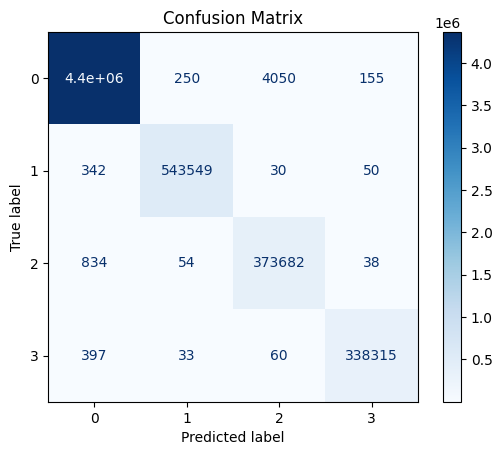

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Generate and plot confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_flat_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

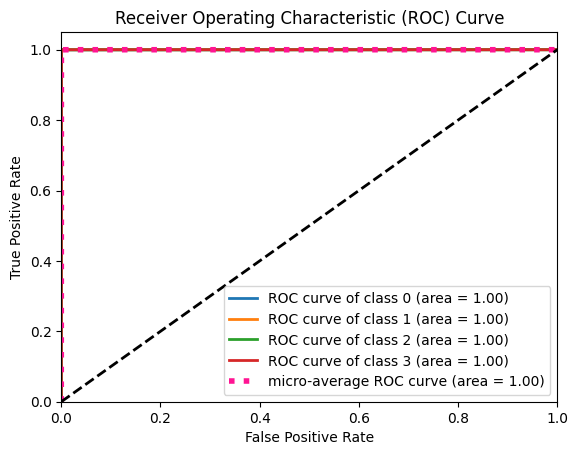

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Flatten the predictions and true labels
true_labels = [label for sublist in labels for label in sublist]
flat_predictions = [pred for sublist in predicted_labels for pred in sublist]

# Filter out ignored index (usually -100) in predictions and labels
filtered_true_labels = []
filtered_probabilities = []

for label, prediction in zip(true_labels, predictions.reshape(-1, predictions.shape[-1])):
    if label != -100:
        filtered_true_labels.append(label)
        filtered_probabilities.append(prediction)

filtered_true_labels = np.array(filtered_true_labels)
filtered_probabilities = np.array(filtered_probabilities)

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(torch.tensor(filtered_probabilities), dim=-1).numpy()

# Convert true labels to binary format for ROC AUC calculation
n_classes = len(label_names)
filtered_true_labels_bin = label_binarize(filtered_true_labels, classes=range(n_classes))

# Calculate ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(filtered_true_labels_bin[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(filtered_true_labels_bin.ravel(), probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure()
lw = 2

# Plot ROC curve for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'
                                          ''.format(label_names[i], roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [ ]:
print(f"Shape of filtered_true_labels_bin: {filtered_true_labels_bin.shape}")
print(f"Shape of probabilities: {probabilities.shape}")

Shape of filtered_true_labels_bin: (5624240, 4)
Shape of probabilities: (5829632, 4)
